In [1]:
#from MuZeroParallel import MuZero as MuZeroP

from MuZero import MuZero

from GridWorldOption import GridWorldOption


from GridWorld import GridWorld

from mcts.MCTS import MCTS
import numpy as np
import matplotlib.pyplot as plt

from random import choice
from copy import deepcopy
import time

import pickle
import pandas as pd

from matplotlib.pyplot import figure
import itertools
from tqdm import tqdm


In [2]:
MAP_NAME = './maps/door.map'

options = [
      GridWorldOption((0, 0),  {'all'}, 0, 0),
      GridWorldOption((0, 0),  {'all'}, 1, 1),
      GridWorldOption((0, 0),  {'all'}, 2, 2),
      GridWorldOption((0, 0),  {'all'}, 3, 3)
]

with open(MAP_NAME) as f:
    the_map = f.read()

In [3]:
first_room_pos = [(i,j) for i in range(6) for j in range(8)]
second_room_pos = [(i,j) for i in range(6) for j in range(9, 15)]
third_room_pos = [(i,j) for i in range(7,13) for j in range(8)]
fourth_room_pos = [(i,j) for i in range(7,13) for j in range(9,15)]

full_options = [
  # primitives, (0,0) is meaningless
  GridWorldOption((0, 0),   {'all'}, 0, 0),
  GridWorldOption((0, 0),   {'all'}, 1, 1),
  GridWorldOption((0, 0),   {'all'}, 2, 2),
  GridWorldOption((0, 0),   {'all'}, 3, 3),
  GridWorldOption((3,8),  set(first_room_pos + second_room_pos + [(6,3)] + [(6,13)]), 4),
  GridWorldOption((6,3),  set(first_room_pos + third_room_pos + [(3,8)] + [(11,8)]), 5),
  GridWorldOption((6,13), set(second_room_pos + fourth_room_pos + [(3,8)] + [(11,8)]), 6),
  GridWorldOption((11,8), set(third_room_pos + fourth_room_pos + [(6,3)] + [(6,13)]), 7),
]    

env = GridWorld(the_map)

G_model = {}
for position in tqdm(env.possible_positions):
    for option in full_options:
        if option.is_valid(position):
            
            test_env = GridWorld(the_map)
            test_env.cur_x = position[0]
            test_env.cur_y = position[1]
            rewards = []
            while True:
                action, should_break = option.get_action(test_env)
                
                if action == -1:
                    break
                
                next_position, r, _ = test_env.step(action)
                rewards.append(r)
                
                if should_break:
                    break
                
            G_model[(position, option)] = (next_position, rewards)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 2001.13it/s]


In [4]:
SIMULATIONS = 40
SIM_FINISHS = 10000
GAMES = 500
ALPHA=0.01

In [5]:
env = GridWorld(the_map, SIM_FINISHS)
mu = MuZero(env, options)

#mu.g.model_table = G_model


In [6]:
start = time.time()
returns = mu.learn(GAMES, SIMULATIONS, alpha=ALPHA)

end = time.time()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.26it/s]


In [7]:
#mu.load('models/den204_hard_2.pickle')

env = GridWorld(the_map, 5000)
env.reset()

total = mu.play(env, SIMULATIONS)
    
print(total)

-24.0


In [8]:
env = GridWorld(the_map, 5000)
env.reset()

total_return = 0
done = False

states = []
while not done:
    s0 = mu.h.forward(env)

    mcts = MCTS(s0, mu.f, mu.g, mu.options)
    pi = mcts.run_sim(SIMULATIONS)

    #opt = np.random.choice(mu.options, 1, p=pi)[0]
    opt_index = np.argmax(pi)
    opt = mu.options[opt_index]
    
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states.append(s)

        total_return += r
        
        if should_break:
            break

print(total_return)

-24.0


In [9]:
with open(MAP_NAME) as f:
    env_map = f.read()
    
env_map = env_map.split('\n')[4:]


grid = np.zeros((len(env_map), len(env_map[0])))
for i in range(len(env_map)):
    for j in range(len(env_map[0])):
        if env_map[i][j] != '.':
            grid[i][j] = -1
        else:
            grid[i][j] = 0

In [10]:
mini = min(mu.f.v_table.values())
maxi = max(mu.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

[]

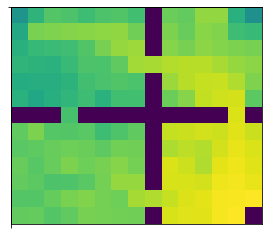

In [11]:
_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [12]:
play_grid = deepcopy(grid)

In [13]:
for s in states:
    play_grid[s] = 2

In [14]:
print(states)

[(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 6), (2, 7), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (4, 11), (4, 12), (5, 12), (5, 13), (6, 13), (7, 13), (8, 13), (9, 13), (10, 13), (11, 13), (12, 13), (12, 14)]


[]

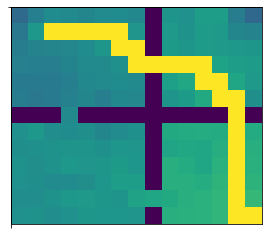

In [15]:
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

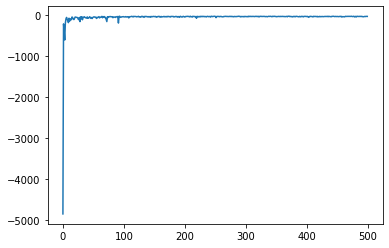

In [16]:
plt.plot(returns[0:1000])

In [17]:
mu.f.v_table[(1,1)]

-26.508143275868342

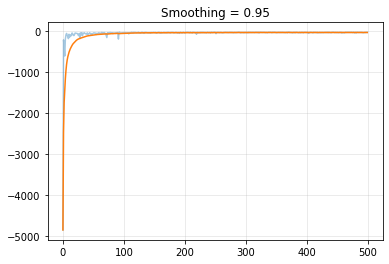

In [18]:
df = pd.DataFrame(data = {'value': np.array(returns)})

SMOOTHING = 0.95
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()


plt.plot(df["value"], alpha=0.4)
plt.plot(smooth["value"])
plt.title("Smoothing = {}".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.show()

In [19]:
first_room_pos = [(i,j) for i in range(6) for j in range(8)]
second_room_pos = [(i,j) for i in range(6) for j in range(9, 15)]
third_room_pos = [(i,j) for i in range(7,13) for j in range(8)]
fourth_room_pos = [(i,j) for i in range(7,13) for j in range(9,15)]

options = [
  # primitives, (0,0) is meaningless
  GridWorldOption((0, 0),   {'all'}, 0, 0),
  GridWorldOption((0, 0),   {'all'}, 1, 1),
  GridWorldOption((0, 0),   {'all'}, 2, 2),
  GridWorldOption((0, 0),   {'all'}, 3, 3),
  GridWorldOption((3,8),  set(first_room_pos + second_room_pos + [(6,3)] + [(6,13)]), 4),
  GridWorldOption((6,3),  set(first_room_pos + third_room_pos + [(3,8)] + [(11,8)]), 5),
  GridWorldOption((6,13), set(second_room_pos + fourth_room_pos + [(3,8)] + [(11,8)]), 6),
  GridWorldOption((11,8), set(third_room_pos + fourth_room_pos + [(6,3)] + [(6,13)]), 7),
]

with open(MAP_NAME) as f:
    the_map = f.read()
    
env = GridWorld(the_map, SIM_FINISHS )
mu_opt = MuZero(env, options)
#mu_opt.g.model_table = G_model



In [20]:
start = time.time()
returns_options = mu_opt.learn(GAMES, SIMULATIONS, alpha=ALPHA)
end = time.time()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.82it/s]


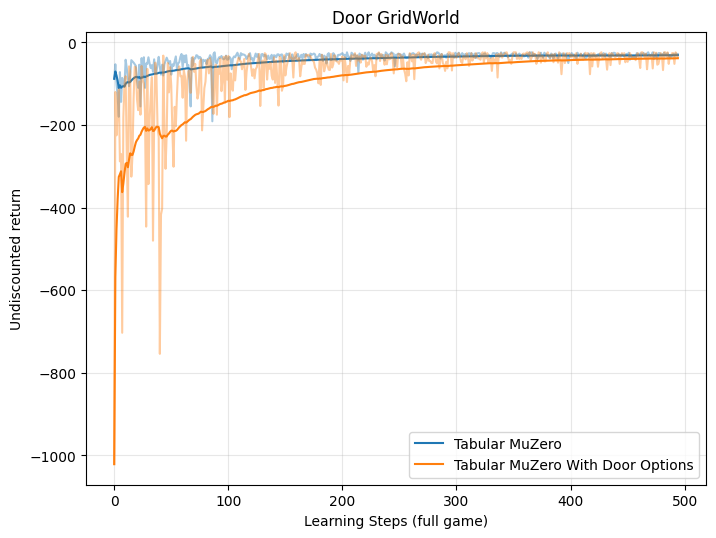

In [37]:
df = pd.DataFrame(data = {'value': np.array(returns[5:])})
df_options = pd.DataFrame(data = {'value': np.array(returns_options[5:])})

figure(figsize=(8, 6), dpi=100)

SMOOTHING = 0.99
smooth = df.ewm(alpha=(1 - SMOOTHING)).mean()
smooth_options = df_options.ewm(alpha=(1 - SMOOTHING)).mean()

plt.plot(df["value"], alpha=0.4, color='#1f77b4')
plt.plot(smooth["value"], color='#1f77b4', label='Tabular MuZero')
plt.plot(df_options["value"], alpha=0.4, color='#ff7f0e')
plt.plot(smooth_options["value"], color='#ff7f0e', label='Tabular MuZero With Door Options')

plt.title("Door GridWorld".format(SMOOTHING))
plt.grid(alpha=0.3)

plt.xlabel("Learning Steps (full game)")
plt.ylabel("Undiscounted return")
plt.legend()
plt.show()

In [38]:
mu_opt.f.p_table[(1,1)]

array([0.05326615, 0.64354263, 0.07604504, 0.0518987 , 0.02516037,
       0.15008711, 0.        , 0.        ])

In [23]:
env = GridWorld(the_map, 1000)
env.reset()

total_return = 0
done = False

states = []
options = []
mu_p = mu_opt
while not done:
    s0 = mu_p.h.forward(env)

    mcts = MCTS(s0, mu_p.f, mu_p.g, mu_p.options)
    pi = mcts.run_sim(40)

    #opt = np.random.choice(mu_p.options, 1, p=pi)[0]
    opt_index = np.argmax(pi)
    opt = mu_p.options[opt_index]
    
    options.append(opt)
    states_by_opt = []
    while True:
        action, should_break = opt.get_action(env)
        
        if action == -1 or done:
            break
        
        s, r, done = env.step(action)
        states_by_opt.append(s)
        

        total_return += r
        
        if should_break:
            break
        
    states.append(states_by_opt)

print(total_return)

-1000.0


[]

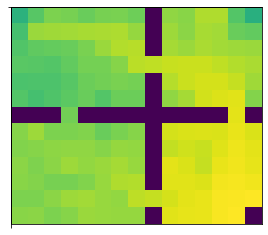

In [24]:
mini = min(mu_p.f.v_table.values())
maxi = max(mu_p.f.v_table.values())
for k, v in mu.f.v_table.items():
    grid[k] = (v - mini)/(maxi-mini)

_, ax = plt.subplots()
ax.imshow(grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [25]:
options

[1,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


[]

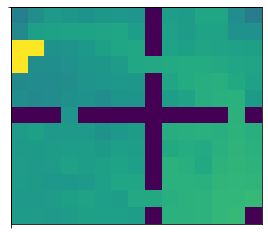

In [26]:
play_grid = deepcopy(grid)
for s in list(itertools.chain(*states)):
    play_grid[s] = 2
_, ax = plt.subplots()
ax.imshow(play_grid)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(-0.5, 0, 1))
ax.set_yticks(np.arange(-0.5, 0, 1))

ax.set_yticklabels([])
ax.set_xticklabels([])

ax.set_title('')

ax.plot()

In [27]:
keys =[ key for key in mu_opt.g.model_table.keys() if key[0] == (1,1)]

In [28]:
keys

[((1, 1), 0), ((1, 1), 3), ((1, 1), 1), ((1, 1), 5), ((1, 1), 2), ((1, 1), 4)]

In [29]:
a = []
for k in keys:
    a.append((k, mu_opt.g.model_table[k]))

In [30]:
mu_opt.f.v_table[(6,3)]

-22.85621733226534

In [31]:
#from MuZeroParallel import MuZero as MuZeroP

from MuZero import MuZero

from GridWorldOption import GridWorldOption


from GridWorld import GridWorld

from mcts.MCTS import MCTS
import numpy as np
import matplotlib.pyplot as plt

from random import choice
from copy import deepcopy
import time

import pickle
import pandas as pd

from matplotlib.pyplot import figure
import itertools


In [32]:
def get_g(full_options):
    env = GridWorld(the_map)

    G_model = {}
    for position in tqdm(env.possible_positions):
        for option in full_options:
            if option.is_valid(position):

                test_env = GridWorld(the_map)
                test_env.cur_x = position[0]
                test_env.cur_y = position[1]
                rewards = []
                while True:
                    action, should_break = option.get_action(test_env)

                    if action == -1:
                        break

                    next_position, r, _ = test_env.step(action)
                    rewards.append(r)

                    if should_break:
                        break

                G_model[(position, option)] = (next_position, rewards)
    return G_model

In [33]:
MAP_NAME = './maps/door.map'
with open(MAP_NAME) as f:
    the_map = f.read()

    
first_room_pos = [(i,j) for i in range(6) for j in range(8)]
second_room_pos = [(i,j) for i in range(6) for j in range(9, 15)]
third_room_pos = [(i,j) for i in range(7,13) for j in range(8)]
fourth_room_pos = [(i,j) for i in range(7,13) for j in range(9,15)]

options = [
  # primitives, (0,0) is meaningless
  GridWorldOption((0, 0),   {'all'}, 0, 0),
  GridWorldOption((0, 0),   {'all'}, 1, 1),
  GridWorldOption((0, 0),   {'all'}, 2, 2),
  GridWorldOption((0, 0),   {'all'}, 3, 3),
  GridWorldOption((3,8),  {(1,1)},  4),#set(first_room_pos + second_room_pos + [(6,3)] + [(6,13)]), 4),
  GridWorldOption((6,3),  set(first_room_pos + third_room_pos + [(3,8)] + [(11,8)]), 5),
  GridWorldOption((6,13), set(second_room_pos + fourth_room_pos + [(3,8)] + [(11,8)]), 6),
  GridWorldOption((11,8), set(third_room_pos + fourth_room_pos + [(6,3)] + [(6,13)]), 7),
]    

env = GridWorld(the_map)
mu_debug = MuZero(env, options)


s_next = mu_debug.env.reset()


s0 = s_next


In [34]:
# mu_debug.f.v_table[(1,1)] = util(24)

# mu_debug.f.v_table[(2,1)] = util(23)
# mu_debug.f.v_table[(1,2)] = util(23)

# mu_debug.f.v_table[(0,1)] = util(25)
# mu_debug.f.v_table[(1,0)] = util(25)

# mu_debug.f.v_table[(3,8)] = util(15)
# mu_debug.f.v_table[(6,3)] = util(17)

In [35]:
mu_debug.f.v_table = get_v()

NameError: name 'get_v' is not defined

In [ ]:
# mu_debug.g.model_table[((1, 1), options[4])] = ((3, 8), [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])

# mu_debug.g.model_table[((1, 1), options[3])] = ((1, 0), [-1.0])
# mu_debug.g.model_table[((1, 1), options[1])] = ((2, 1), [-1.0])
# mu_debug.g.model_table[((1, 1), options[5])] = ((6, 3), [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
# mu_debug.g.((self.N * self.Q) model_table[((1, 1), options[2])] = ((1, 2), [-1.0])
# mu_debug.g.model_table[((1, 1), options[0])] = ((0, 1), [-1.0])mu_debug.g

In [ ]:
mu_debug.g.model_table = get_g(options)

In [ ]:
mcts = MCTS(s0, mu_debug.f, mu_debug.g, mu_debug.options)

In [ ]:
mcts.run_sim(1000)